In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import xarray as xr

import seaborn as sns
sns.set_theme(style="whitegrid")  # 推荐

def create_mask(years, base_path,env_category,env_name, chunks="auto"):
    masks = []
    for y in years:
        data_tmpl = f"{base_path}/{env_category}/{y}/xr_total_{env_category}_{y}.nc"
        data_xr  = xr.open_dataarray(data_tmpl.format(year=y), chunks=chunks)
        cost_tml = f"{base_path}/{env_category}/{y}/xr_{env_name}_{y}.nc"
        cost_xr = xr.open_dataarray(cost_tml.format(year=y), chunks=chunks)
        # m = (data_xr >= 1) & (cost_xr >= 1)
        m = data_xr >=1
        masks.append(m.expand_dims(year=[y]))
    mask = xr.concat(masks, dim="year")
    mask.name = "mask"
    mask.attrs["description"] = "True if both env and cost >= 1, else False"
    return mask

In [22]:
def create_xarray(years, base_path, env_category, env_name,mask=None,
                  engine="h5netcdf",
                  cell_dim="cell", cell_chunk="auto",
                  year_chunk=1, parallel=False):
    """
    以 year 维度拼接多个年度 NetCDF，懒加载+分块，避免过多文件句柄。
    """
    file_paths = [
        os.path.join(base_path, str(env_category), str(y), f"xr_{env_name}_{y}.nc")
        for y in years
    ]
    missing = [p for p in file_paths if not os.path.exists(p)]
    if missing:
        raise FileNotFoundError(f"以下文件未找到:\n" + "\n".join(missing))

    # 从文件名提取实际年份，确保坐标与文件顺序一致
    valid_years = [int(os.path.basename(p).split("_")[-1].split(".")[0]) for p in file_paths]

    ds = xr.open_mfdataset(
        file_paths,
        engine=engine,
        combine="nested",          # 明确“按给定顺序拼接”
        concat_dim="year",         # 新增 year 维度
        parallel=parallel,         # 一般 False 更稳，避免句柄并发
        chunks={cell_dim: cell_chunk, "year": year_chunk}  # year=1，cell 分块
    ).assign_coords(year=valid_years)
    
    if mask is not None:
        ds = ds.where(mask, other=0)  # 使用掩码，非掩码区域设为 0

    return ds

def sum_except_year(obj: xr.Dataset | xr.DataArray) -> xr.Dataset | xr.DataArray:
    """
    对 xarray 对象在除 'year' 以外的所有维度上求和。
    支持 DataArray 和 Dataset。
    """
    if isinstance(obj, xr.DataArray):
        return obj.sum(dim=set(obj.dims) - {"year"})
    elif isinstance(obj, xr.Dataset):
        return obj.map(lambda v: v.sum(dim=set(v.dims) - {"year"}))
    else:
        raise TypeError("输入必须是 xarray.DataArray 或 xarray.Dataset")

In [23]:
import os
import xarray as xr
from joblib import Parallel, delayed


def process_file(file_path, year_idx, cat, mask_year=None):
    """
    处理单个文件：加载 -> (可选)按当年mask筛选 -> 对所有非year维求和 -> 返回 year 维标量
    """
    print(f"Processing {file_path}")
    ds_one = xr.open_dataset(file_path, chunks="auto")
    main_var = next(iter(ds_one.data_vars))
    da = ds_one[main_var]

    # 如果给了当年的 mask，先对齐再筛选
    if mask_year is not None:
        # 对齐到共同维度（一般是 cell）
        da, mask_year = xr.align(da, mask_year, join="inner")
        da = da.where(mask_year)

    # 对除 "year" 以外的所有维求和成一个标量
    reduce_dims = [d for d in da.dims if d != "year"]
    s = da.sum(dim=reduce_dims)

    # 保证是标量（如果还带着year坐标，取该年的值）
    if "year" in s.dims:
        s = s.sel(year=year_idx)

    return xr.Dataset({cat: xr.DataArray([s], dims=["year"], coords={"year": [year_idx]})})


def create_cost_year_series(
    years,
    base_path,
    env_category,
    mask=None,                 # <- 新增：可选的 (year, cell) 布尔mask
    year_chunk=-1,
    parallel=True,
    cost_categories=("cost_ag",
                     "cost_agricultural_management",
                     "cost_non_ag",
                     "cost_transition_ag2ag_diff",
                     "transition_cost_ag2non_ag_amortised_diff"),
    finalize="compute",        # "lazy" | "persist" | "compute"
):
    """
    对每个 cost_category:
      - 逐文件打开，(可选)应用 mask(year, cell)
      - 将所有非year维求和成标量
      - 拼出 1D 年序列
    合并所有 cost_category，并追加 TOTAL。
    返回：
      da_year: DataArray, 维度 (cost_category, year)，含 'TOTAL'
    """

    # 如果提供了 mask，限定有效年份为交集（避免 mask 没有的年份报错）
    years = list(years)
    if mask is not None:
        mask_years = set(mask.coords["year"].values.tolist())
        years_in_both = [y for y in years if y in mask_years]
        if not years_in_both:
            raise ValueError("提供的 mask 不包含任何所需年份。")
        if len(years_in_both) != len(years):
            missing = sorted(set(years) - set(years_in_both))
            print(f"[WARN] 这些年份不在mask中，将跳过：{missing}")
        years = years_in_both

    per_cat_ds = []

    for cat in cost_categories:
        # 生成文件路径
        paths = [os.path.join(base_path, str(env_category), str(y),
                              f"xr_{cat}_{env_category}_{y}.nc")
                 for y in years]
        exist = [p for p in paths if os.path.exists(p)]
        if not exist:
            raise FileNotFoundError(f"未找到 {cat} 的 NetCDF 文件。")

        # 文件对应的年份
        valid_years = [int(os.path.basename(p).split("_")[-1].split(".")[0]) for p in exist]

        # 为并行准备每年的当年mask切片（若有）
        mask_slices = None
        if mask is not None:
            # 确保 mask 是按年可索引的
            mask_slices = {y: mask.sel(year=y) for y in valid_years}

        # 并行或串行处理
        if parallel:
            ds_list = Parallel(n_jobs=-1, backend="loky")(
                delayed(process_file)(
                    file_path,
                    valid_years[idx],
                    cat,
                    mask_slices[valid_years[idx]] if mask_slices is not None else None
                )
                for idx, file_path in enumerate(exist)
            )
        else:
            ds_list = [
                process_file(
                    file_path,
                    valid_years[idx],
                    cat,
                    mask_slices[valid_years[idx]] if mask_slices is not None else None
                )
                for idx, file_path in enumerate(exist)
            ]

        # 沿 year 维拼接
        ds_cat = xr.concat(ds_list, dim="year").assign_coords(year=valid_years)
        if year_chunk > 0 and finalize != "compute":
            ds_cat = ds_cat.chunk({"year": year_chunk})
        per_cat_ds.append(ds_cat)

    # 合并所有 cost_category -> (cost_category, year)
    ds_year = xr.merge(per_cat_ds, compat="override", join="exact")
    da_year = ds_year.to_array(dim="cost_category").transpose("cost_category", "year")

    # 追加 TOTAL
    da_total = da_year.sum(dim="cost_category", skipna=True).expand_dims(cost_category=["TOTAL"])
    da_year = xr.concat([da_year, da_total], dim="cost_category")

    # 计算策略
    if finalize == "compute":
        return da_year.compute()
    if finalize == "persist":
        return da_year.persist()
    return da_year

def quick_plot(da, title, figure_path):
    fig, ax = plt.subplots(figsize=(5, 4))

    # 添加 marker 参数创建点线图
    da.plot(ax=ax, marker='o', linestyle='-', markersize=4)
    ax.set(ylabel='', title=title,xlabel='')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_path, title+".png"))
    plt.show()

In [24]:
task_name = '20250831_Price_Task_NCI'
base_path = f"../../../output/{task_name}/carbon_price/0_base_data"
excel_path = f"../../../output/{task_name}/carbon_price/1_excel"
figure_path = f"../../../output/{task_name}/carbon_price/2_figure"
os.makedirs(excel_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)

env_category = "bio_50"
env_name = f"total_cost_{env_category}_amortised"
years = list(range(2011, 2051))
xr_bio_mask = create_mask(years, base_path,env_category, env_name)

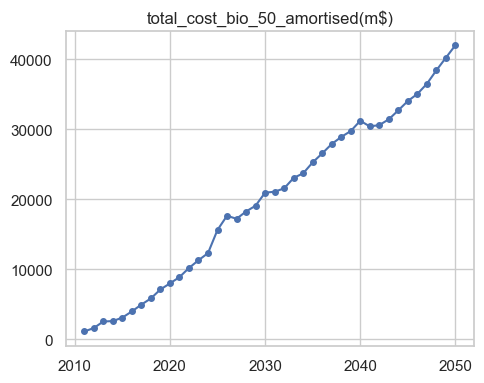

In [27]:
xr_bio_cost_a = create_xarray(years, base_path, env_category, env_name)
da = (xr_bio_cost_a["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}(m$)', figure_path)

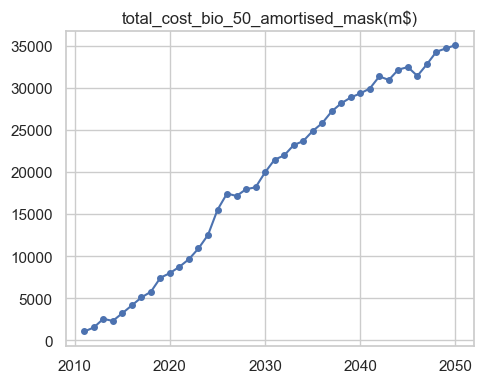

In [28]:
xr_bio_cost_a_m = create_xarray(years, base_path, env_category, env_name, mask=xr_bio_mask)
da = (xr_bio_cost_a_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}_mask(m$)', figure_path)

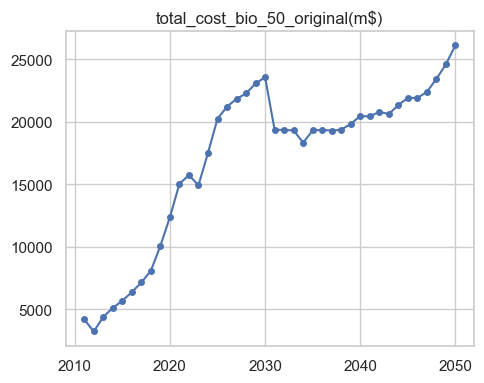

In [29]:
env_name = f"total_cost_{env_category}_original"
xr_bio_cost_o = create_xarray(years, base_path, env_category, env_name)
da = (xr_bio_cost_o["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}(m$)', figure_path)

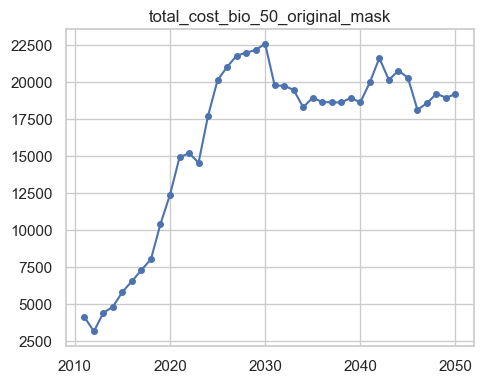

In [30]:
env_name = f"total_cost_{env_category}_original"
xr_bio_cost_o_m = create_xarray(years, base_path, env_category, env_name, mask=xr_bio_mask)
da = (xr_bio_cost_o_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}_mask', figure_path)

In [31]:
# env_category = "bio_50"
# xr_bio_cost_series = create_cost_year_series(years, base_path, env_category, mask=xr_bio_mask)
# df_bio_cost = xr_bio_cost_series.T.to_pandas() / 1e6
# df_bio_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
# df_bio_cost

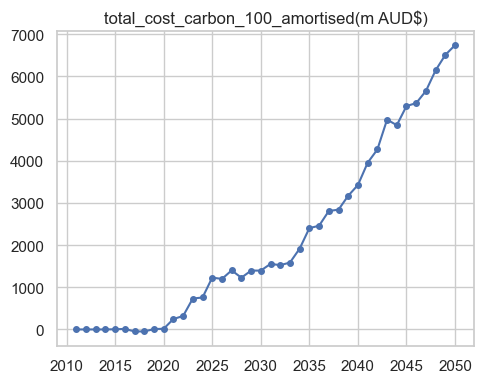

In [32]:
env_category = "carbon_100"
env_name = f"total_cost_{env_category}_amortised"
xr_carbon_mask = create_mask(years, base_path,env_category, env_name)
xr_carbon_cost_a = create_xarray(years, base_path, env_category, env_name)
da= (xr_carbon_cost_a["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}(m AUD$)', figure_path)

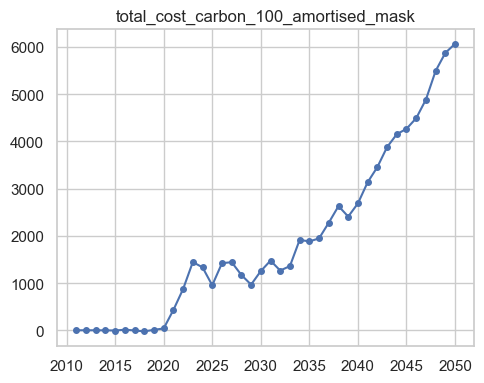

In [33]:
xr_carbon_cost_a_m = create_xarray(years, base_path, env_category, env_name, mask=xr_carbon_mask)
da= (xr_carbon_cost_a_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}_mask', figure_path)

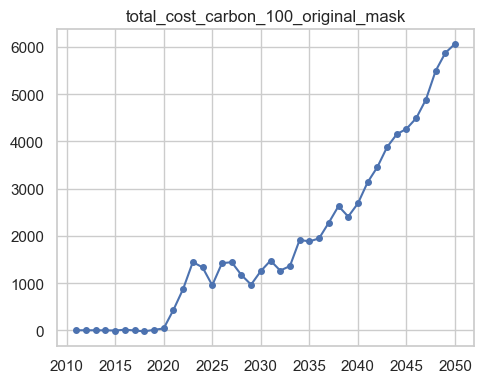

In [34]:
env_name = f"total_cost_{env_category}_original"
xr_carbon_cost_o_m = create_xarray(years, base_path, env_category, env_name, mask=xr_carbon_mask)
da= (xr_carbon_cost_a_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}_mask', figure_path)

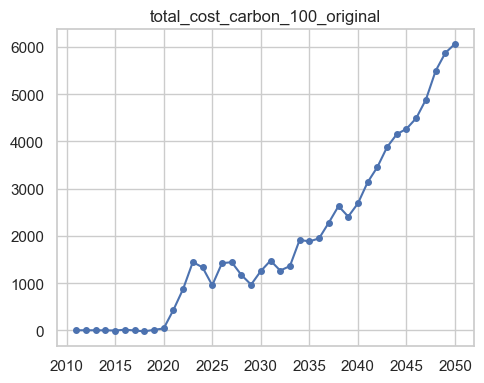

In [35]:
env_name = f"total_cost_{env_category}_original"
xr_carbon_cost_o = create_xarray(years, base_path, env_category, env_name)
da= (xr_carbon_cost_a_m["data"].sum(dim="cell") / 1e6).sortby("year")
quick_plot(da, f'{env_name}', figure_path)

In [36]:
# xr_carbon_cost_series = create_cost_year_series(years, base_path, env_category, mask=xr_carbon_mask)
# df_carbon_cost =  xr_carbon_cost_series.T.to_pandas() / 1e6
# df_carbon_cost.to_excel(os.path.join(excel_path, f"{env_category}_cost_series.xlsx"))
# df_carbon_cost

In [37]:
xr_carbon_m = create_xarray(years, base_path, "carbon_100", f"total_{env_category}", mask=xr_carbon_mask)
xr_carbon = create_xarray(years, base_path, "carbon_100", f"total_{env_category}")

In [38]:
xr_carbon_price = xr_carbon_cost_a/xr_carbon*xr_carbon_mask

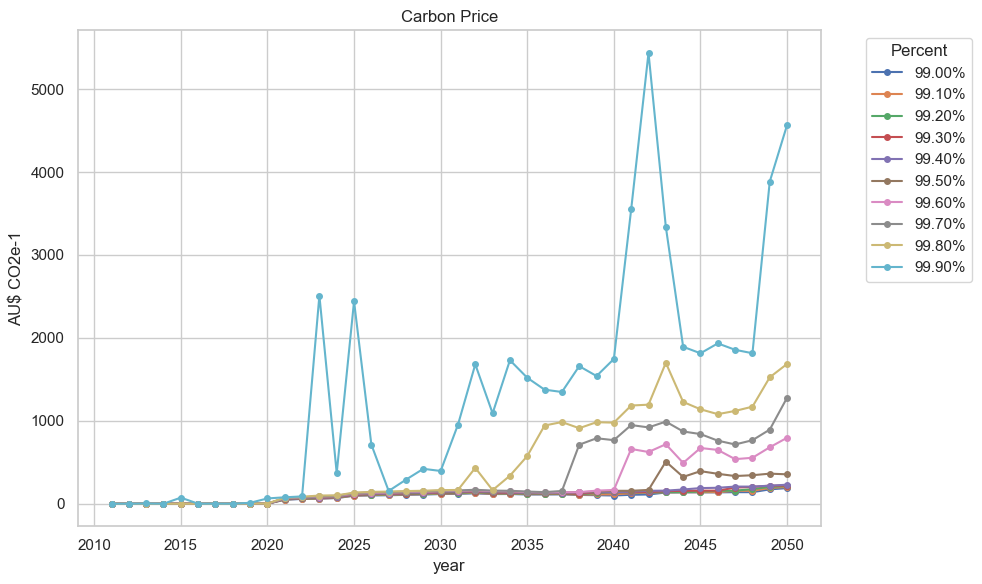

In [63]:
import matplotlib.pyplot as plt
import numpy as np

da = xr_carbon_price["data"]  # (year, cell)

# 1) 计算每年在 cell 维度上的 85%~99% 分位数
qs = da.quantile(q=np.arange(0.99, 0.999, 0.001), dim="cell", skipna=True)  # (quantile, year)

# 2) 画多条分位数曲线
fig, ax = plt.subplots(figsize=(10,6))
qs.T.plot.line(x="year", ax=ax,marker="o",markersize=4, add_legend=False)  # 不要自动图例

# 3) 手动指定图例标签
labels = [f"{q*100:.2f}%" for q in qs.coords["quantile"].values]
ax.legend(labels, title="Percent", bbox_to_anchor=(1.05,1), loc="upper left")

ax.set(ylabel="AU$ CO2e-1",title="Carbon Price")
plt.tight_layout()
plt.show()


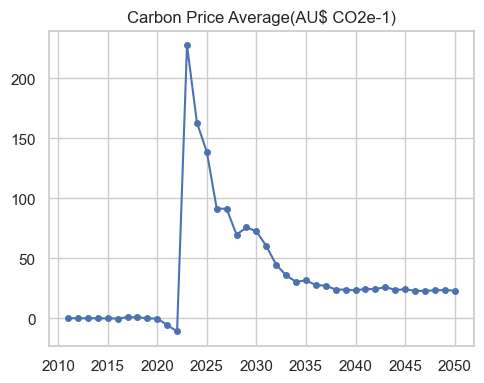

In [74]:
xr_carbon_price_ave = (xr_carbon_cost_a.sum(dim="cell")/xr_carbon.sum(dim="cell"))
da = xr_carbon_price_ave["data"]
quick_plot(da, "Carbon Price Average(AU$ CO2e-1)", figure_path)

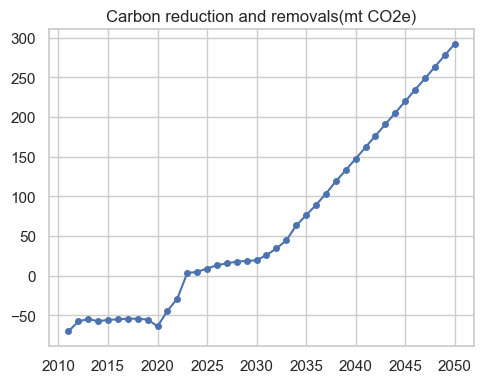

In [82]:
da = xr_carbon.sum(dim='cell')["data"] / 1e6
quick_plot(da, "Carbon reduction and removals(mt CO2e)", figure_path)

In [51]:
xr_bio = create_xarray(years, base_path, "bio_50", f"total_bio_50")
xr_bio_price = xr_bio_cost_a/xr_bio*xr_bio_mask

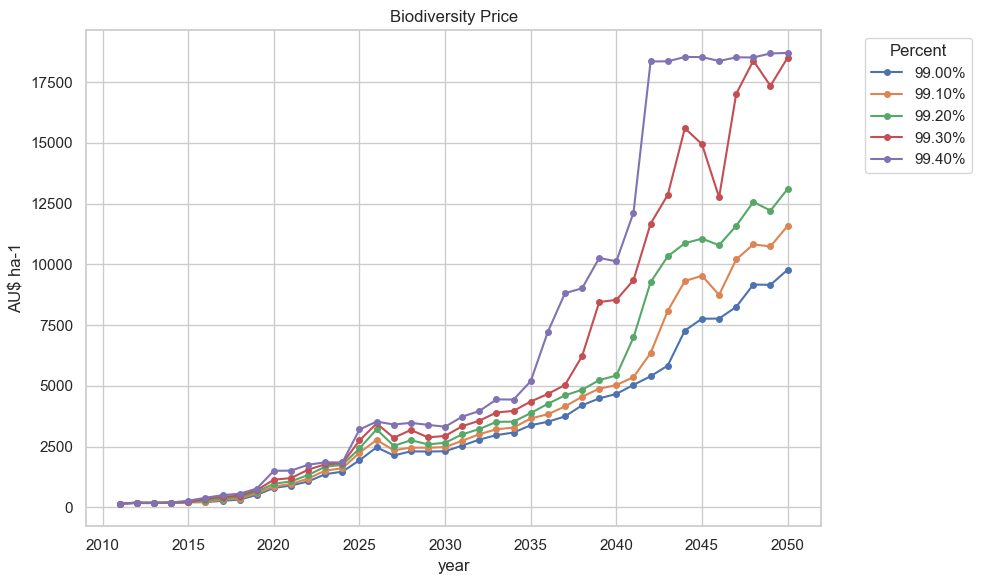

In [58]:
import matplotlib.pyplot as plt
import numpy as np

da = xr_bio_price["data"]  # (year, cell)

# 1) 计算每年在 cell 维度上的 85%~99% 分位数
qs = da.quantile(q=np.arange(0.99, 0.994, 0.001), dim="cell", skipna=True)  # (quantile, year)

# 2) 画多条分位数曲线
fig, ax = plt.subplots(figsize=(10,6))
qs.T.plot.line(x="year", ax=ax,marker="o",markersize=4, add_legend=False)  # 不要自动图例

# 3) 手动指定图例标签
labels = [f"{q*100:.2f}%" for q in qs.coords["quantile"].values]
ax.legend(labels, title="Percent", bbox_to_anchor=(1.05,1), loc="upper left")

ax.set(ylabel="AU$ ha-1",title="Biodiversity Price")
plt.tight_layout()
plt.show()


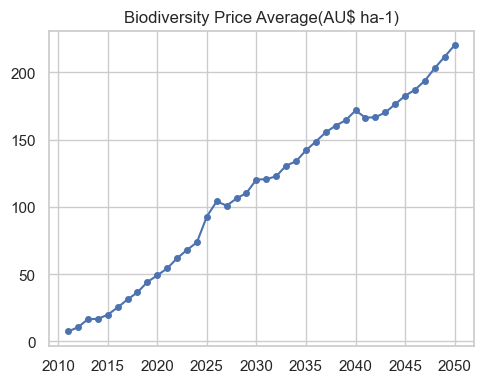

In [80]:
xr_bio_price_ave = (xr_bio_cost_a.sum(dim="cell")/xr_bio.sum(dim="cell"))
da = xr_bio_price_ave["data"]
quick_plot(da, "Biodiversity Price Average(AU$ ha-1)", figure_path)

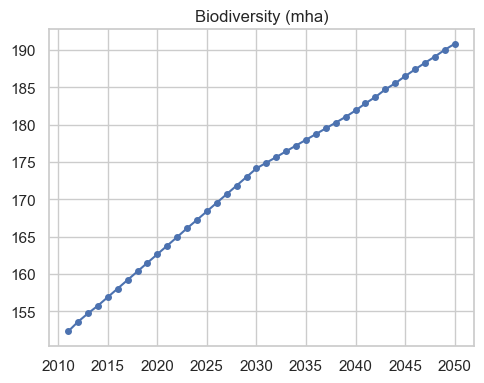

In [83]:
da = xr_bio.sum(dim='cell')["data"] / 1e6
quick_plot(da, "Biodiversity (mha)", figure_path)